# LSTM model one-hot applicatie inputs

In [39]:
from torch import optim
from data.dataloader import DatasetLoader
from torch.utils.data import DataLoader
import torch
from models.LSTM import LSTM
from torch import nn
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Dataset uitlezen en cleanen

In [40]:
""" batch size 16 voor pre-trainen """
dataset = DatasetLoader("eventlog/phone_usage_cleaned.csv", seq_length=10)
removeapps = ["Screen on (locked)",
              "Screen off (locked)",
              "Screen on (unlocked)",
              "Screen off",
              "Samsung Experience Service",
              "Package installer",
              "System UI",
              "Customisation Service",
              "Configuration update",
              "EmergencyManagerService",
              "DeviceKeystring",
              "Samsung Keyboard",
              "HwModuleTest",
              "Device shutdown",
              "Device boot"]
dataset.clean(removeapps)
train_dataloader = DataLoader(dataset, batch_size=16)

## 2. LSTM model aanmaken en pre-trainen

In [41]:
""" stel device in als CUDA indien mogelijk """
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

""" Gebruikt LSTM klasse
    Vervangt embedding matrix door eenheidsmatrix met vaste gewichten
    Trainingsnelheid zal iets lager zijn dan model met echte one-hot input
"""
lstm = LSTM(max_apps=200,
            n_lstm=64,
            src_dim=200,
            bidirectional=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.001)

main_diagonal = torch.ones(size=[200])
lstm.src_embedding.weight = torch.nn.Parameter(torch.diag(input=main_diagonal))
lstm.src_embedding.weight.requires_grad = False

lstm.to(device=device)

LSTM(
  (src_embedding): Embedding(200, 200)
  (lstm): LSTM(200, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=200, bias=True)
)

In [42]:
epochs = 10
training_samples = 1600
testing_samples = 400

traincorrect = 0
valcorrect = 0

trainacchistory = []
trainlosshistory = []
valacchistory = []
vallosshistory = []
epoch = []

for j in range(epochs):

    sample = 0
    traincorrect = 0
    trainloss = 0
    valcorrect = 0
    valloss = 0

    for prev_apps_indices, curr_app_index in train_dataloader:
        prev_apps_indices, curr_app_index = prev_apps_indices.to(device), curr_app_index.to(device)

        h0, c0 = lstm.init_hidden(batch_size=16)
        h = (h0.to(device), c0.to(device))

        # Niet meer dan 1600 eerste samples gebruiken
        if sample < training_samples:
            # Batch size increment
            sample+=prev_apps_indices.shape[0]

            # Reset gradient
            optimizer.zero_grad()

            # Output continue logit vector
            outputs, h = lstm(prev_apps_indices, h)

            # Cat Crossentropy met logsoftmax
            loss = criterion(outputs, curr_app_index)

            trainloss += loss.item()*prev_apps_indices.shape[0]

            # Optimize weights
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            traincorrect += (predicted == curr_app_index).sum().item()

        elif training_samples <= sample < training_samples + testing_samples:
            # Batch size increment
            sample+=prev_apps_indices.shape[0]

            # Reset gradient
            optimizer.zero_grad()

            # Output continue logit vector
            outputs, h = lstm(prev_apps_indices, h)

            # Cat Crossentropy met logsoftmax
            loss = criterion(outputs, curr_app_index)

            valloss += loss.item()*prev_apps_indices.shape[0]

            _, predicted = torch.max(outputs.data, 1)
            valcorrect += (predicted == curr_app_index).sum().item()

        else:
            break

    trainacchistory.append(traincorrect/(training_samples))
    trainlosshistory.append(trainloss/(training_samples))
    valacchistory.append(valcorrect/(testing_samples))
    vallosshistory.append(valloss/(testing_samples))
    epoch.append(j)


    # print("epoch nr: " +  str(j))
    # print(traincorrect/(training_samples))
    # print(valcorrect/(testing_samples))
    # print()

## 3. Plot pre-training history

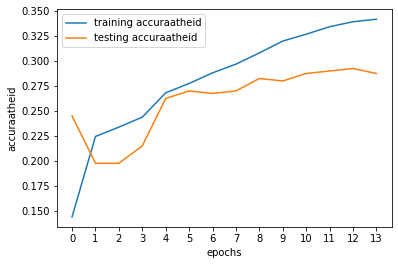

0.2925
2.818228850364685


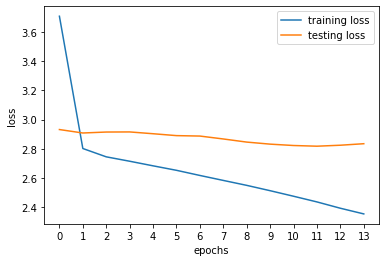

In [43]:
plt.plot(trainacchistory, label="training accuraatheid")
plt.plot(valacchistory, label="testing accuraatheid")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuraatheid')
plt.xticks(epoch)
plt.savefig(fname="outputdata/bigruonehotpretrainacc.png")
plt.show()
print(max(valacchistory))

plt.plot(trainlosshistory, label="training loss")
plt.plot(vallosshistory, label="testing loss")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.xticks(epoch)
plt.savefig(fname="outputdata/bigruonehotpretrainloss.png")
plt.show()
print(min(vallosshistory))

## 4. LSTM model online learning

In [44]:
""" Dataloader mag nu niet langer batches produceren """
train_dataloader = DataLoader(dataset, batch_size=1)

In [45]:
running_accuracy_list = []
sample = 0

h0, c0 = lstm.init_hidden(batch_size=1)
h = (h0.to(device), c0.to(device))

for prev_apps_indices, curr_app_index in tqdm(train_dataloader):
    prev_apps_indices, curr_app_index = prev_apps_indices.to(device), curr_app_index.to(device)

    # Online learning, 1 sample
    sample += 1

    if sample > training_samples + testing_samples - 9:

        # Make prediction
        outputs, h = lstm(prev_apps_indices, h)

        # Measure accuracy top-k
        _, predicted = torch.topk(outputs.data, 5)
        running_accuracy_list.append(curr_app_index in predicted)

        # Calculate loss
        loss = criterion(outputs, curr_app_index)

        # Cat Crossentropy met logsoftmax
        loss.backward()
        optimizer.step()

        # Reset gradient
        optimizer.zero_grad()

100%|██████████| 33627/33627 [00:58<00:00, 573.36it/s]


In [46]:
print(sum(running_accuracy_list)/len(running_accuracy_list))
print(len(running_accuracy_list))

0.731887722847389
31636


## 3. Running accuracy opslaan

In [28]:
AccuracyComparison = pd.read_csv("outputdata/accuracycomparison.csv", index_col=False)
AccuracyComparison["onehotlstm64"] = running_accuracy_list
AccuracyComparison.to_csv("outputdata/accuracycomparison.csv", index=False)
AccuracyComparison.head()


,MFU,MRU,onehotbigru,onehotlstm128,onehotlstm64,onehotgru64,onehotgru128
0,True,True,True,True,True,True,True
1,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False
3,False,True,False,False,False,False,False
4,False,True,False,False,False,False,False
